In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import libpysal as ps
import shapefile
from shapely.geometry import shape
import osr
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\g_onz\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\g_onz\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\g_onz\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:199: N

In [2]:
"""
Author: Eder González Ramos
Date: September 7th, 2023
Description: It creates a map about Mexico's population with a distribution by municipality
"""

"\nAuthor: Eder González Ramos\nDate: September 7th, 2023\nDescription: It creates a map about Mexico's population with a distribution by municipality\n"

In [3]:
shp_path="C:/Users/g_onz/Box/07 Proyectos de Data/001 shape/Municipios/"
graph_path="C:/Users/g_onz/Dropbox/Proyectos_Data/0002_Población mexico/Graphs/"
file="Municipios"

In [4]:
####SHP file and GEOM
pth = (shp_path+file+".shp")
pth_prj=  (shp_path+file+".prj")
tracts = shapefile.Reader(pth, encoding='latin')

fields = [field[0] for field in tracts.fields[1:]]
attributes = []
geometry = []

for row in tracts.shapeRecords():
    geometry.append(shape(row.shape.__geo_interface__))
    attributes.append(dict(zip(fields, row.record)))

with open(pth_prj) as p:
    proj4 = osr.SpatialReference(p.read()).ExportToProj4()
print(proj4)  

gdf = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)

+proj=lcc +lat_0=12 +lon_0=-102 +lat_1=17.5 +lat_2=29.5 +x_0=2500000 +y_0=0 +ellps=GRS80 +units=m +no_defs


In [5]:
df=pd.read_csv("C:/Users/g_onz/Dropbox/Proyectos_Data/0002_Población mexico/Raw/ITER_NALCSV20.csv")

C:\Users\g_onz\AppData\Local\Temp\ipykernel_11972\617134877.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("C:/Users/g_onz/Dropbox/Proyectos_Data/0002_Población mexico/Raw/ITER_NALCSV20.csv")


In [6]:
df = df[ (df['NOM_ENT']!="Total nacional") & (df['MUN']!=0)  & (df["NOM_LOC"]=="Total del Municipio") ]
df=df[['ENTIDAD','MUN','POBTOT']]
df['ENTIDAD']=df['ENTIDAD'].astype('str')
df['MUN']=df['MUN'].astype('str')
df['len_MUN']=df['MUN'].str.len()
df['len_ENT']=df['ENTIDAD'].str.len()

df['MUN_temp']=np.where(df['len_MUN']==1, "00"+df['MUN'], np.where(df['len_MUN']==2, "0"+df['MUN'], "00"+df['MUN'])    )
df['ENT_temp']=np.where(df['len_ENT']==1, "0"+df['ENTIDAD'], df['ENTIDAD'])
df['CVEGEO']=df['ENT_temp']+df['MUN_temp']
df.drop(['len_MUN','len_ENT',"MUN_temp","ENT_temp","ENTIDAD","MUN"], axis=1, inplace=True)

gdf=gdf.merge(df, on="CVEGEO", how='left')


In [13]:
#from shapely.geometry import Polygon, LineString, Point
#new_gdf=gdf[gdf['Estado']=="Guerrero"]
new_gdf=gdf
new_gdf["POBTOT_"]=new_gdf["POBTOT"]/1000
text_x= new_gdf.geometry.bounds.minx.min()
text_y= new_gdf.geometry.bounds.miny.min()


PermissionError: [Errno 13] Permission denied: 'C:/Users/g_onz/Dropbox/Proyectos_Data/0002_Población mexico/Graphs/mexico.pdf'

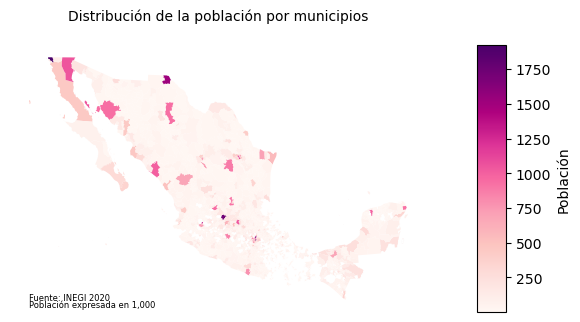

In [25]:
###

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.5)

new_gdf.plot("POBTOT_", cmap="RdPu", edgecolor="white", linewidth=0.0005, alpha=1,
          legend=True, aspect=1,
          ax=ax,
          cax=cax,
          legend_kwds={"label":"Población" , "orientation": "vertical"},
          missing_kwds={'color':'white'})
ax.set_axis_off()
ax.text((text_x) ,(text_y), s="Fuente: INEGI 2020",  fontdict={'fontsize':"6"}) #GRO
ax.text((text_x) ,(text_y-60000), s="Población expresada en 1,000",  fontdict={'fontsize':"6"}) #GRO
ax.set_title("Distribución de la población por municipios" +"\n"+ "", size=10)
fig.savefig(graph_path+ "mexico.pdf", bbox_inches="tight", facecolor="#F6F2EF")

